<a href="https://colab.research.google.com/github/kristina-skoptsova/diplom/blob/main/diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [10]:
file = '/content/final2.csv'
df = pd.read_csv(file)
df = pd.DataFrame(df)
df

,Направление,Год поступления,Количество абитуриентов,Баллы ЕГЭ,Возраст,Вступительный балл,Регион рождения,Уровень безработицы,Доля женщин,Доля квоты,Доля волонтерства
0,1,1908,11,-0.397620,-0.302921,1.480258,1.480258,33.793476,0.110471,-0.932472,0.965381
1,1,1909,11,-0.323680,-1.201973,-0.165480,-0.165480,29.929197,-0.607585,0.270533,-0.579118
2,1,1910,11,-1.186287,-1.799674,-1.610080,-1.610080,27.189645,-0.639556,-0.748223,0.253945
3,1,1911,11,-0.042719,0.749308,0.567303,0.567303,32.609474,-0.455643,-0.761783,0.345629
4,1,1912,11,0.957904,0.521211,-0.084162,-0.084162,29.937970,-0.938985,-0.640584,-0.386541
...,...,...,...,...,...,...,...,...,...,...,...
5962,51,2020,19,-0.147270,0.738005,-1.956321,-1.956321,17.091670,-0.354391,0.620962,-0.424094
5963,51,2021,20,0.816437,0.244920,0.138422,0.138422,17.964293,-0.627167,-0.408057,-0.517372
5964,51,2022,20,-0.284249,0.575489,-1.744231,-1.744231,16.264727,1.417724,0.041130,-0.011007
5965,51,2023,20,-0.598730,-0.907030,-0.052447,-0.052447,18.913300,0.567138,0.897687,-0.776967


In [11]:
X = df.drop(columns=['Количество абитуриентов'])
y = df['Количество абитуриентов']

In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Функция для создания последовательностей данных
def create_sequences(data, window_size):
    inputs, outputs, groups = [], [], []
    for direction in data['Направление'].unique():
        dir_data = data[data['Направление'] == direction].sort_values('Год поступления')
        for i in range(len(dir_data) - window_size):
            seq = dir_data.iloc[i:i+window_size].drop(['Направление', 'Год поступления', 'Количество абитуриентов'], axis=1).values
            target = dir_data.iloc[i+window_size]['Количество абитуриентов']
            direction_label = dir_data.iloc[i+window_size]['Направление']  # Направление для следующего шага
            inputs.append(seq)
            outputs.append(target)
            groups.append(direction_label)
    return np.array(inputs), np.array(outputs), np.array(groups)

# Создание последовательностей
YEARS_SIZE = 3
X, y, direction_labels = create_sequences(df, YEARS_SIZE)

# Нормализация целевой переменной
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test, direction_train, direction_test = train_test_split(
    X, y, direction_labels, test_size=0.2, random_state=42)

# Рассчитываются веса только для тренировочной выборки
unique_directions, direction_counts_train = np.unique(direction_train, return_counts=True)
direction_weights_train = {direction: 1.0 / count for direction, count in zip(unique_directions, direction_counts_train)}

# Применение весов к данным
sample_weights = df['Направление'].map(direction_weights_train).values

# Ограничение веса для тренировочной выборки
train_sample_weights = sample_weights[:len(y_train)]

# Архитектура модели
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(YEARS_SIZE, X.shape[2])),
     tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Компиляция модели
model.compile(optimizer='adam', loss='mae')

# Обучение модели
history = model.fit(
    X_train,
    y_train,
    sample_weight=train_sample_weights,  # Использование веса
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

# Оценка модели на тестовой выборке
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 12/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms

In [23]:
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)  # Обратное преобразование
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Вычисление ошибки для каждого направления
test_df = pd.DataFrame({
    'Направление': direction_test,
    'Фактическое': y_test_original.flatten(),
    'Предсказанное': predictions.flatten()
})

mae_by_direction = test_df.groupby('Направление').apply(
    lambda x: np.mean(np.abs(x['Фактическое'] - x['Предсказанное']))
)
mae_by_direction

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-23-79cfd66f6fc7>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_direction = test_df.groupby('Направление').apply(


,0
Направление,
1.0,3.766137
2.0,4.250907
3.0,4.739781
4.0,3.248765
5.0,3.863977
6.0,4.456885
7.0,4.543087
8.0,4.065544
9.0,3.625363


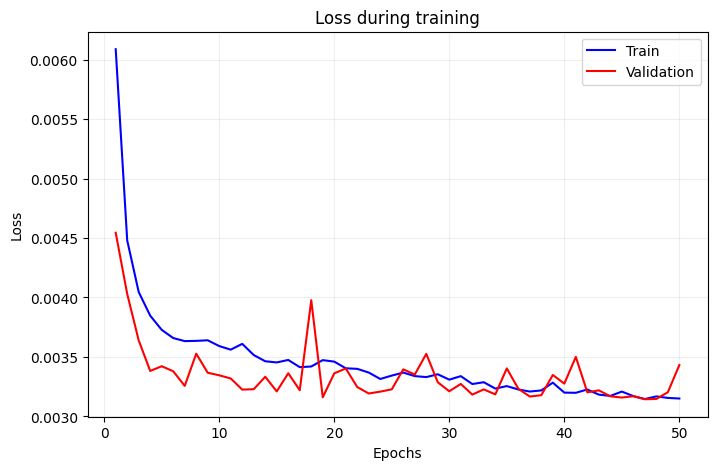

In [27]:
import matplotlib.pyplot as plt

def show_training(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b', label='Train')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.2)
    plt.show()

# Вызов функции после обучения модели
show_training(history)